In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from atl_module.plotting import set_size

In [3]:
aoidflist = []
for aoifile in glob("../data/test_sites/oahu*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined = pd.concat(aoidflist)

In [4]:
tracklines_dflist = [
    gpd.read_file(file) for file in glob("../data/test_sites/oahu*/tracklines")
]
tracklines_combined = pd.concat(tracklines_dflist).reset_index()

In [5]:
dflist = []

for file in glob("../data/test_sites/oahu*/all_bathy_pts.gpkg"):
    df = gpd.read_file(file)
    sitename = file.split("/")[3].strip("oahu")
    df["Oahu site number"] = sitename
    dflist.append(df)

df = pd.concat(dflist).reset_index()

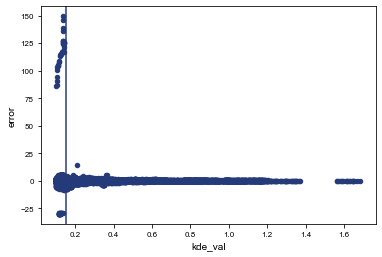

In [6]:
ax = df.plot.scatter(x="kde_val", y="error")
ax.axvline(0.15)

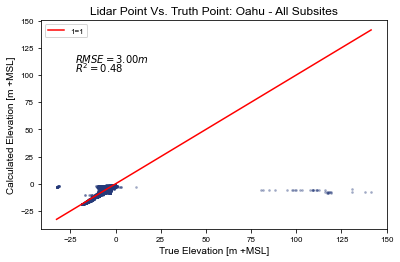

In [7]:
df_nona = df.dropna()
errordict = {
    "RMSE": df_nona.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df_nona.true_elevation, df_nona.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df_nona, "Oahu - All Subsites", errordict)
ax.get_figure().savefig(
    "../document/figures/Oahu_combined_lidar_estimated_vs_truth.pdf"
)

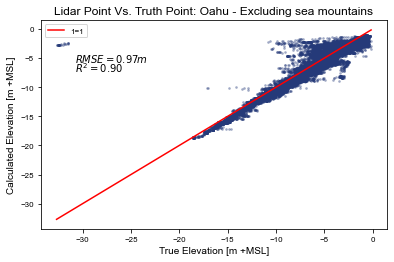

In [8]:
df_nona = df_nona[df_nona.true_elevation < 0]
errordict = {
    "RMSE": df_nona.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df_nona.true_elevation, df_nona.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df_nona, "Oahu - Excluding sea mountains", errordict)
ax.get_figure().savefig(
    "../document/figures/Oahu_combined_mountains_removed_lidar_estimated_vs_truth.pdf"
)

plotting photon map
finished plotting photons
finished adding basemap


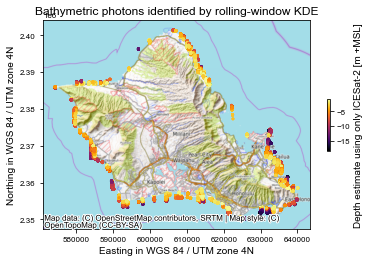

In [9]:
fig, ax = plt.subplots(figsize=set_size())
plot_photon_map(ax, df)
fig.savefig("../document/figures/Oahu_all_sites_photon_points.pdf")

plotting tracklines
finished plotting tracklines
finished plotting basemap


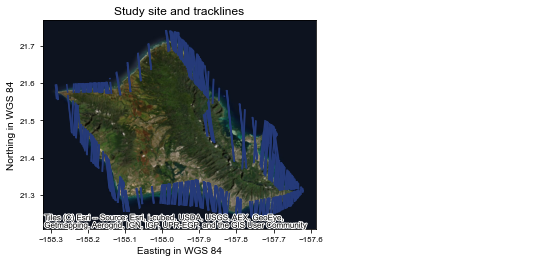

In [10]:
aoi_combined, trackax = plt.subplots(figsize=set_size())
plot_tracklines_overview(trackax, tracklines_combined)
trackax.plot(
    column="site", categorical=True, legend=True, facecolor="none", lw=3, ax=trackax
)
# TODO fix categorical coloring on this
aoi_combined.savefig("../document/figures/Oahu_all_tracklines.pdf")

In [11]:
df.columns

Index(['index', 'X', 'Y', 'Z_ellip', 'Z_geoid', 'geoid_corr',
       'tide_ocean_corr', 'geof2m_corr', 'delta_time', 'oc_sig_conf',
       'land_sig_conf', 'p_vec_az', 'p_vec_elev', 'dac_corr', 'ph_count',
       'full_sat', 'gebco_elev', 'sea_level_interp', 'sea_level_std_dev',
       'Z_refr', 'easting_corr', 'northing_corr', 'z_kde', 'kde_val', 'beam',
       'atm_profile', 'beamtype', 'oc_hconf_perc', 'easting_raw',
       'northing_raw', 'sf_elev_MSL', 'true_elevation', 'error', 'error_abs',
       'geometry', 'Oahu site number'],
      dtype='object')

In [12]:
import numpy as np

rms_agg = lambda x: np.sqrt(np.mean(np.square(x)))

summary_table = (
    df.groupby("Oahu site number")
    .agg({"error": rms_agg, "error_abs": "mean", "X": "count"})
    .rename(
        columns={
            "error": "RMSE",
            "error_abs": "MAE",
            "X": "Count bathy Points Identified",
        }
    )
)
summary_table.style.to_latex(
    buf="../document/tables/Oahu_all_sites_RMSE_summary.tex",
    caption="Error metrics between ICESat-2 and ground-truth data for all sites in Oahu",
    position="h!",
    sparse_columns=False,
    hrules=True,
)
summary_table

,RMSE,MAE,Count bathy Points Identified
Oahu site number,,,
1,1.162525,0.768264,12727
2,10.598899,1.447226,4327
3,1.235418,0.463914,18556
4,0.753487,0.567063,2717
5,0.734813,0.504969,10443
6,2.422447,1.756412,754
7,1.111055,0.717672,2949
8,0.670264,0.520953,17929
